In [ ]:
# default_exp downloader

# Downloader

> `Downloaders` are a one of the main block of web2dataset. They define the code to scrap the web for multi-model data

In [ ]:
# hide
%load_ext autoreload
%autoreload 2

In [ ]:
# hide
from nbdev.showdoc import *

here is the abstract class for the Downloader 

In [ ]:
# export
import os
import urllib
import uuid
from abc import ABC, abstractmethod
from typing import List, Optional

from docarray import Document, DocumentArray
from rich.progress import Progress

In [ ]:
# export
class Downloader(ABC):
    _DOCS_FILE_NAME = "dataset.bin"

    def __init__(
        self, path: str, silence: bool = False, dataset_fn: str = "dataset.bin"
    ):
        """
        path: folder in which to save the files
        silence: to silence the logging and the progress bar
        dataset_fn: name of the file in which to save the docarray dataset, by default dataset.bin
        """
        self.docs: DocumentArray = DocumentArray()

        self.path = path[0:-2] if path[-1] == "/" else path
        os.makedirs(path, exist_ok=True)

        self.silence = silence
        self.dataset_fn = dataset_fn

    def download(self, query: str, n_item: int):
        """Scrap internet and download some files
        query: a tag to define the download query
        n_item: the number of file to download
        """
        with Progress(disable=self.silence) as progress:

            progress.add_task("Scrapping...", total=n_item)
            self._download(query, n_item, progress)
            self._save_docs()

    @abstractmethod
    def _download(self, query: str, n_item: int, progress: Progress, task_id: int = 0):
        """Internal method wrap around downlaod method
        query: a tag to define the download query
        n_item: the number of file to download
        progress: rich progress bar
        task_id: the number of the rich task
        """
        ...

    @property
    def path_docs(self):
        return f"{self.path}/{self.dataset_fn}"

    def _save_docs(self):
        """Save the metadata"""
        with open(self.path_docs, "wb") as f:
            f.write(self.docs.to_bytes())

Example: simple Downloader:
this class will be used for testing

In [ ]:
test_folder = "/tmp/test"

In [ ]:
# hide
import shutil

shutil.rmtree(test_folder, ignore_errors=True)

In [ ]:
import time


class BasicDownloader(Downloader):
    def _get_doc(self) -> Document:
        return Document(
            tag={
                "origin": "https://www.google.fr",
                "image_url": "https://raw.githubusercontent.com/fastai/fastai/master/nbs/images/puppy.jpg",
            }
        )

    def _download(self, query: str, n_item: int, progress: Progress, task_id: int = 0):
        self.docs.extend((self._get_doc() for _ in range(n_item)))
        progress.update(task_id, advance=n_item)
        time.sleep(0.1)

let's define a downloader that will search random wallpaper on the web

In [ ]:
downloader = BasicDownloader(f"{test_folder}/my_search")
downloader.download("wallpaper", 2)
assert len(downloader.docs) == 2

Output()

Under the hood the `Downloader` save everything in memory in a `DocumentArray` from the [docarray](https://docarray.jina.ai/) package

In [ ]:
downloader.docs

            Documents Summary            
                                         
  Length                 2               
  Homogenous Documents   True            
  Common Attributes      ('id', 'tags')  
                                         
                     Attributes Summary                     
                                                            
  Attribute   Data type   #Unique values   Has empty value  
 ────────────────────────────────────────────────────────── 
  id          ('str',)    2                False            
  tags        ('dict',)   2                False

we can now load the dataset in a `DocumentArray` to use it afterwards

In [ ]:
with open(f"{test_folder}/my_search/dataset.bin", "rb") as f:
    docs = DocumentArray.from_bytes(f.read())

In [ ]:
docs

            Documents Summary            
                                         
  Length                 2               
  Homogenous Documents   True            
  Common Attributes      ('id', 'tags')  
                                         
                     Attributes Summary                     
                                                            
  Attribute   Data type   #Unique values   Has empty value  
 ────────────────────────────────────────────────────────── 
  id          ('str',)    2                False            
  tags        ('dict',)   2                False

Before jumping into creating actual `Downloader` let's define the core error

In [ ]:
# export
class DownloaderError(ValueError):
    pass

## ImageDownloader

In [ ]:
# export
class ImageDownloader(Downloader):
    """
    Specialize abstract downloader for image
    """

    _IMG_SUB_PATH = "images"

    def __init__(self, path: str):
        """
        path: folder in which to save the files
        """
        super().__init__(path)
        os.makedirs(self.path_image, exist_ok=True)

    def _data_url_to_file(self, url: str, id_: str):
        response = urllib.request.urlopen(url)
        with open(f"{self.path_image}/{id_}.jpg", "wb") as f:
            f.write(response.file.read())

    @property
    def path_image(self):
        return f"{self.path}/{self.__class__._IMG_SUB_PATH}"

### Google Image Downloader

> The Google Image Downloader is one of the main `Downloader` of web2dataset

In [ ]:
# export
from contextlib import contextmanager

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.webdriver import WebDriver
from selenium.webdriver.common.by import By
from selenium.webdriver.remote.webelement import WebElement

to use this tutorial you need to have installed the [chrome webdriver](https://chromedriver.chromium.org/downloads) which will play the role of the browser during the downloading

first lets design a simple context manager to open and close the web driver automatically

In [ ]:
# export
@contextmanager
def _get_driver(debug=False):

    if debug:
        driver = webdriver.Chrome()
    else:
        chrome_options = Options()
        chrome_options.add_argument("--headless")
        driver = webdriver.Chrome(options=chrome_options)
    try:
        yield driver
    finally:
        driver.quit()

In [ ]:
with _get_driver() as driver:
    pass

Then we can define the google image downloader

In [ ]:
# export
class GoogleImageDownloaderError(DownloaderError):
    pass

In [ ]:
# export
class GoogleImageDownloader(ImageDownloader):
    """
    GoogleImageDownloader: A downloader to download image from google images

    Example:
    ```python
    >>> from web2dataset import GoogleImageDownloader
    >>> downloader = GoogleImageDownloader(f"tmp/bikedataset")
    >>> downloader.download("red bike", 10)
    ```
    """

    def _download(self, query: str, n_item: int, progress: Progress, task_id: int = 0):
        """Internal method wrap around downlaod method
        query: a tag to define the download query
        n_item: the number of file to download
        progress: rich progress bar
        task_id: the number of the rich task
        """
        google_image_url = self._create_url_from_query(query)
        with _get_driver() as driver:

            driver.get(google_image_url)

            while _continue := len(self.docs) < n_item:

                self._scrap_all_images_in_current_page(
                    driver, query, n_item, progress, task_id
                )
                _continue = len(self.docs) < n_item

                if _continue:
                    self._scroll_to_next_page(driver)

    def _create_url_from_query(self, query: str) -> str:
        if "+" in query:
            raise GoogleImageDownloaderError(
                " + should not be in the query because the whitespace are replaced by + so the meaning is different"
            )
        return f"https://www.google.com/search?q={query.replace(' ','+')}&source=lnms&tbm=isch"

    def _element_to_document(
        self, element, query: str, progress: Progress, task_id: int
    ):
        """
        convert an google image element to a document
        """
        url = element.get_attribute("src")
        id_ = str(uuid.uuid1())

        self._data_url_to_file(url, id_)
        doc = Document(
            uri=f"{self.__class__._IMG_SUB_PATH}/{id_}.jpg",
            tag={"uuid": id_, "origin": query},
        )

        progress.update(task_id, advance=1)

        return doc

    def _find_images(self, driver: WebDriver) -> List[WebElement]:
        return driver.find_elements(By.CLASS_NAME, "rg_i")

    def _scrap_all_images_in_current_page(
        self,
        driver: WebDriver,
        query: str,
        n_item: int,
        progress: Progress,
        task_id: int,
    ):
        elements = self._find_images(driver)
        self.elements = elements
        self.docs.extend(
            [
                self._element_to_document(e, query, progress,task_id)
                for i, e in enumerate(elements)
                if len(self.docs) + i < n_item
            ]
        )

    def _scroll_to_next_page(self, driver: WebDriver):
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")

In [ ]:
downloader = GoogleImageDownloader(f"{test_folder}/bikedataset")

In [ ]:
n_item = 16

In [ ]:
%%time
downloader.download("bike", n_item)

Output()

CPU times: user 206 ms, sys: 25.2 ms, total: 231 ms
Wall time: 2.87 s


In [ ]:
assert len(downloader.docs) == n_item

Now that we downloaded our images let's plot them !

In [ ]:
downloader.docs[0].uri

'images/088fb6f4-9e67-11ec-bee9-645d865124e9.jpg'

In [ ]:
def load_img(d):
    d.uri = f"{test_folder}/bikedataset/{d.uri}"
    d.load_uri_to_image_tensor()
    return d

In [ ]:
downloader.docs = downloader.docs.apply(load_img)

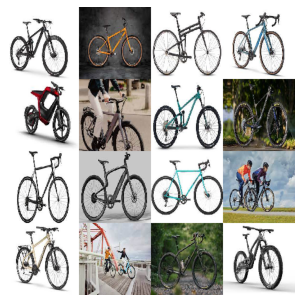

In [ ]:
downloader.docs.plot_image_sprites()

In [ ]:
# hide
shutil.rmtree(test_folder, ignore_errors=True)